# Lesson 1: Cats and Dogs

For this lesson, we'll be using a library called [pytorch-sconce](https://github.com/davidlmorton/pytorch-sconce) to make training and visualization a little easier.  With this library, you first create something called a [DataGenerator](https://davidlmorton.github.io/pytorch-sconce/data_generator.html#sconce.data_generators.DataGenerator) that will load our Cats and Dogs images from disk and get them ready to hand to the pytorch model for training.  Once we can load the data, its just a matter of wrapping the pytorch model in a model class that satisfies the [sconce model restrictions](https://davidlmorton.github.io/pytorch-sconce/models.html#module-sconce.models).  

## For Google Colab (Install pytorch-sconce first)

In [ ]:
!pip install pytorch-sconce==0.9.0

## Imports

In [1]:
from sconce import rate_controllers
from sconce.data_generators import ImageDataGenerator
from sconce.trainers import ClassifierTrainer
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import os
import torch
import torchvision

## Download cats and dogs data

In [2]:
if not os.path.exists('data'):
    !mkdir data && wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data/
else:
    print("Data already downloaded, skipping...")

Data already downloaded, skipping...


## Define DataGenerators

With [sconce](https://github.com/davidlmorton/pytorch-sconce), you first create something called a [DataGenerator](https://davidlmorton.github.io/pytorch-sconce/data_generator.html#sconce.data_generators.DataGenerator) that will load our Cats and Dogs images from disk and get them ready to hand to the pytorch model for training.  The [ImageDataGenerator](https://davidlmorton.github.io/pytorch-sconce/data_generator.html#sconce.data_generators.ImageDataGenerator) will also give us a couple of handy methods to examine the dataset such as `plot_label_summary` and `plot_size_summary`

In [3]:
image_size = 224

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

loader_kwargs = {
    'batch_size': 256,
    'shuffle': True,
    'num_workers': 0
}

training_data_generator = ImageDataGenerator.from_image_folder(
    root='data/dogscats/train',
    transform=transform,
    loader_kwargs=loader_kwargs)

test_data_generator = ImageDataGenerator.from_image_folder(
    root='data/dogscats/valid',
    transform=transform,
    loader_kwargs=loader_kwargs)

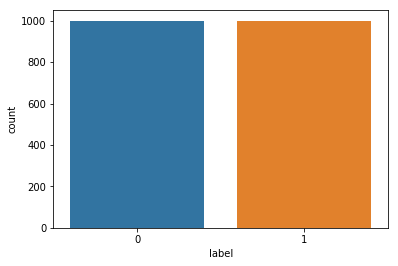

In [4]:
test_data_generator.plot_label_summary();

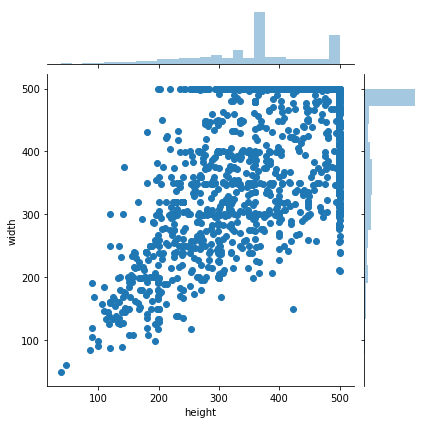

In [5]:
test_data_generator.plot_size_summary();

## Define Model

Once we can load the data, we need to wrap the pytorch model in a class that satisfies the [sconce model restrictions](https://davidlmorton.github.io/pytorch-sconce/models.html#module-sconce.models).  This will then let us construct a [Trainer](https://davidlmorton.github.io/pytorch-sconce/trainers.html#sconce.trainer.Trainer) object to train the model.

In [6]:
class MyModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
    def forward(self, inputs, **kwargs):
        x = self.base_model(inputs)
        x = F.log_softmax(x, dim=1)
        return {'outputs': x}
    
    def calculate_loss(self, targets, outputs, **kwargs):
        return {'loss': F.nll_loss(input=outputs, target=targets)}

    def calculate_metrics(self, targets, outputs, **kwargs):
        y_out = np.argmax(outputs.cpu().data.numpy(), axis=1)
        y_in = targets.cpu().data.numpy()
        num_correct = (y_out - y_in == 0).sum()
        classification_accuracy = num_correct / len(y_in)
        return {'classification_accuracy': classification_accuracy}
    
def create_model():
    # Get a resnet model pretrained on imagenet data (will download training weights).
    base_model = torchvision.models.resnet18(pretrained=True)
    
    # Freeze all layers, so they don't get updated during training.
    for param in base_model.parameters():
        param.requires_grad = False
        
    # Replace last fully-connected layer with one that outputs only two categories (cat / dog).
    # This is now the only layer that isn't yet trained.
    base_model.fc = nn.Linear(in_features=base_model.fc.in_features, out_features=2)
    return MyModel(base_model)

In [7]:
model = create_model()

if torch.cuda.is_available():
    model.cuda()
    training_data_generator.cuda()
    test_data_generator.cuda()

## Construct Trainer

In addition to the model, the trainer also needs a pytorch [optimizer](http://pytorch.org/docs/master/optim.html#module-torch.optim), and the data generators we already made above.  The optimizer needs to know what parameters to optimize, and is responsible for actually changing those parameters based on the losses we calculate during training.  Here we define a [ClassifierTrainer](https://davidlmorton.github.io/pytorch-sconce/sconce.trainers.html#module-sconce.trainers.classifier_trainer) so that we get a couple of handy methods, such as `get_classification_accuracy` and `plot_samples`.

In [8]:
optimizer = optim.Adam(model.base_model.fc.parameters(),
        weight_decay=1e-4)

trainer = ClassifierTrainer(model=model, optimizer=optimizer,
    training_data_generator=training_data_generator,
    test_data_generator=test_data_generator)

## Survey for a Learning Rate

The learning rate is an important hyperparameter to get right, but knowing what values to try can be hard to figure out.  [This blog post](https://medium.com/@davidlmorton/exploring-the-learning-rate-survey-3e328d17cf79) introduces the learning rate survey that [pytorch-sconce](https://github.com/davidlmorton/pytorch-sconce) implements, and goes into some detail about how it can be used to help find a good range of learning rates for a given model and dataset.

In [9]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=0.5,
    min_learning_rate=1e-5,
    max_learning_rate=10,
    stop_factor=3)

35/45 [======================>.......] - ETA: 10s - loss: 0.4688

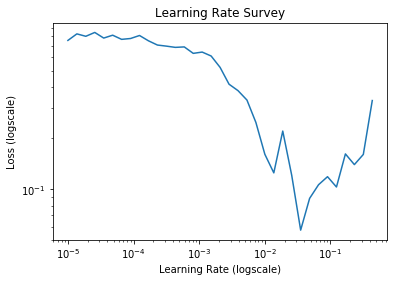

In [10]:
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

## Train Model

To train the model, we need to define a [RateController](https://davidlmorton.github.io/pytorch-sconce/rate_controllers.html#sconce.rate_controllers.RateController) that will be used by the [Trainer](https://davidlmorton.github.io/pytorch-sconce/trainers.html#classifiertrainer) to set the learning rate during training.

In [11]:
rc = rate_controllers.TriangleRateController(
    max_learning_rate=1e-2,
    min_learning_rate=2e-3)
trainer.train(num_epochs=0.4, rate_controller=rc);

36/36 [==============================] - 42s 1s/step - loss: 0.2037 - val_loss: 0.0984


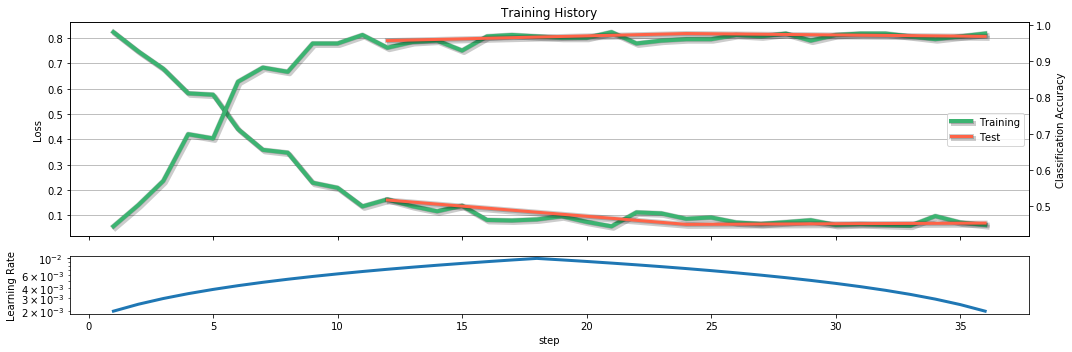

In [12]:
trainer.monitor.dataframe_monitor.plot(
    skip_first=0,
    smooth_window=1,
    metrics=['loss', 'classification_accuracy']);

## Evaluate Model Predictions 

In [13]:
trainer.get_classification_accuracy()

0.971

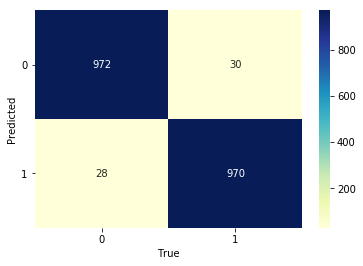

In [14]:
trainer.plot_confusion_matrix();

Misclassified as Dogs
Showing only the first 7 of 28 images


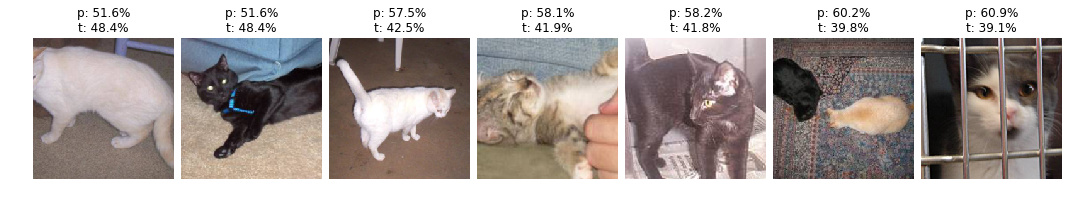

In [15]:
print("Misclassified as Dogs")
trainer.plot_samples(predicted_label=1, true_label=0);

Misclassified as Cats
Showing only the first 7 of 30 images


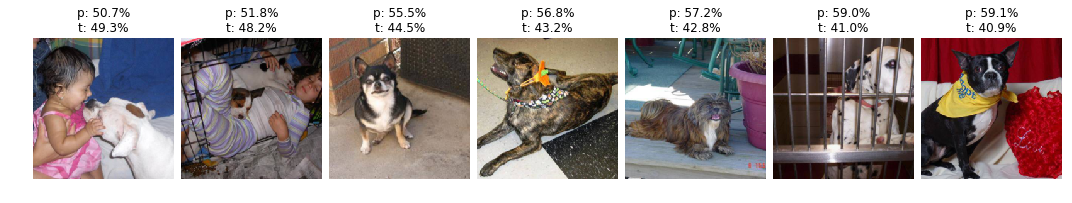

In [16]:
print("Misclassified as Cats")
trainer.plot_samples(predicted_label=0, true_label=1);

Most Dog-like Dogs
Showing only the first 7 of 970 images


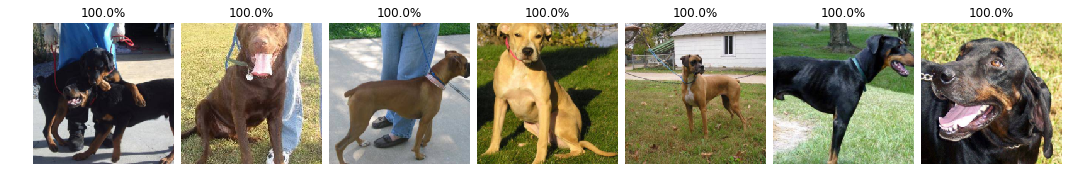

In [17]:
print("Most Dog-like Dogs")
trainer.plot_samples(predicted_label=1, true_label=1, sort_by='falling predicted label score');

Most Cat-like Cats
Showing only the first 7 of 972 images


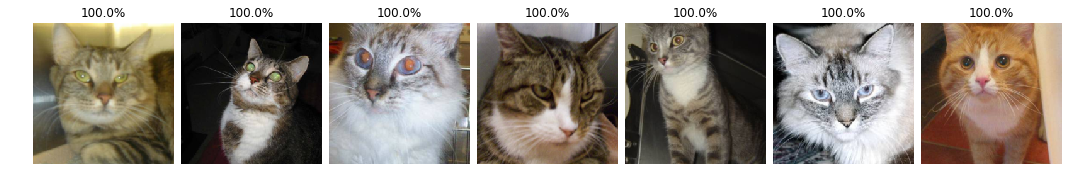

In [18]:
print("Most Cat-like Cats")
trainer.plot_samples(predicted_label=0, true_label=0, sort_by='falling predicted label score');

## Differential Learning Rates

Now, instead of just training the final fully connected layer, we could have also trained all or part of the pretrained base model.  It turns out that fine tuning (retraining) the last set of convolutional layers of the base model will allow us to achieve a better classification accuracy than just training the final fully connected layer.  First we plot the summary of the model and then start "unfreezing" the part of it that we want to fine tune.

In [19]:
model = create_model()
model.cuda()

# Print a model summary
model.base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [20]:
base_model = model.base_model

params_list = []

# ==== layer 4 ====
params = []
for param in base_model.layer4.parameters():
    param.requires_grad = True
    params.append(param)
    
params_list.append({'params': params, 'weight_decay': 1e-4, 'lr': 1e-4})

# ==== fc layer ====
params = []
for param in base_model.fc.parameters():
    param.requires_grad = True
    params.append(param)
    
params_list.append({'params': params, 'weight_decay': 1e-4, 'lr': 1e-4})
    
optimizer = optim.Adam(params_list)

In [21]:
trainer = ClassifierTrainer(model=model, optimizer=optimizer,
    training_data_generator=training_data_generator,
    test_data_generator=test_data_generator)

37/45 [=======================>......] - ETA: 9s - loss: 0.2861 

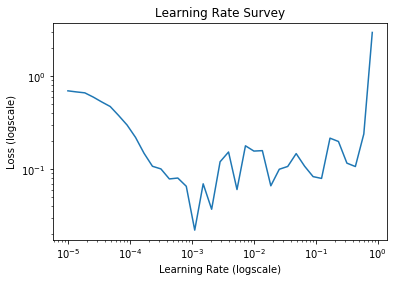

In [22]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=0.5,
    min_learning_rate=1e-5,
    max_learning_rate=10,
    stop_factor=20)
survey_monitor.dataframe_monitor.plot_learning_rate_survey();

In [23]:
base_lr = 1e-3

layer_factor = 0.1
max_lr = base_lr * layer_factor
min_lr = max_lr / 10
rc_layer_4 = rate_controllers.TriangleRateController(
    max_learning_rate=max_lr, min_learning_rate=min_lr)

layer_factor = 1.0
max_lr = base_lr * layer_factor
min_lr = max_lr / 10
rc_fc_layer = rate_controllers.TriangleRateController(
    max_learning_rate=max_lr, min_learning_rate=min_lr)

rc = rate_controllers.base.CompositeRateController([rc_layer_4, rc_fc_layer])

81/81 [==============================] - 102s 1s/step - loss: 0.1310 - val_loss: 0.0918


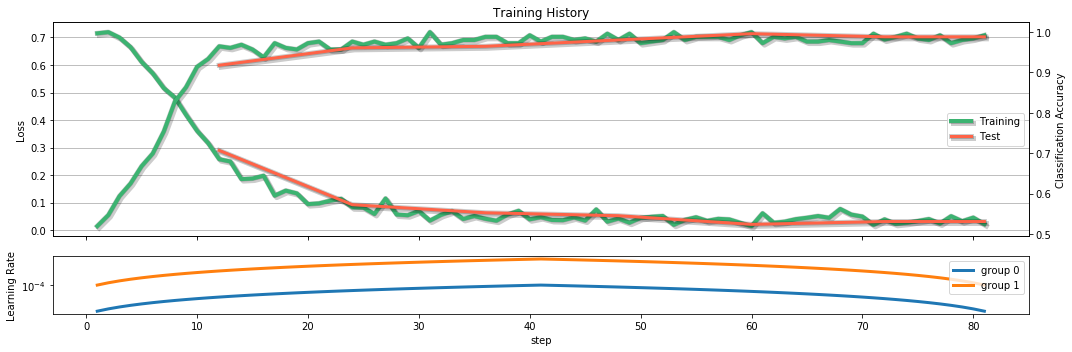

In [24]:
trainer.train(num_epochs=0.9, rate_controller=rc)
trainer.monitor.dataframe_monitor.plot(
    skip_first=0,
    smooth_window=1,
    metrics=['loss', 'classification_accuracy']);

In [25]:
trainer.get_classification_accuracy()

0.984

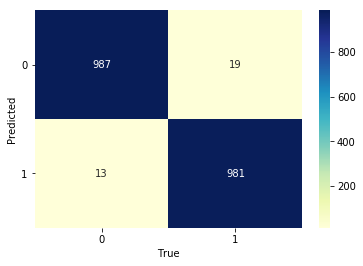

In [26]:
trainer.plot_confusion_matrix();

Misclassified as Dogs
Showing only the first 7 of 13 images


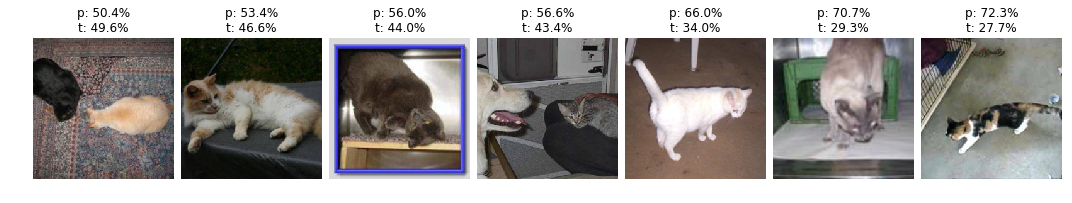

In [27]:
print("Misclassified as Dogs")
trainer.plot_samples(predicted_label=1, true_label=0);

Misclassified as Cats
Showing only the first 7 of 19 images


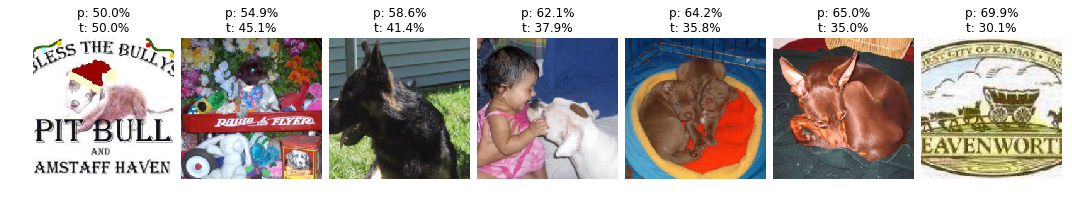

In [28]:
print("Misclassified as Cats")
trainer.plot_samples(predicted_label=0, true_label=1);